# House Pricing Predictions
This is my attempt on the data science challenge on [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview), predicting the house prices given a large number of features. 

## Preliminary work: imports and loading data

In [287]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

In [288]:
# variables to store the location of the training and test datasets
train_file = "train.csv"
test_file = "test.csv"

In [289]:
df_train_org = pd.read_csv(train_file)
df_test_org = pd.read_csv(test_file)
# df and df_test are copies of the original datasets with target value referred to as y
Y = "y"
df = df_train_org.rename(columns={'SalePrice': Y})
df_test = df_test_org.rename(columns={'SalePrice':Y})

## Data Exploration 
In this section we explore the basic aspects of the provided dataset.

In [290]:
# a function to drop an element to both train and test dataframes
def drop_cols(col_names:list, on='both'):
    global df, df_test
    try:
        df = df.drop(col_names, axis=1)
        df_test = df_test.drop(col_names, axis=1)
    except:
        print("The column{s} {cols} have already been dropped".
        format(s= "" if (col_names is str or len(col_names) == 1) else "s", cols=str(col_names)))
    

In [291]:
# let's first understand the nature of our data
print(df.shape, df_test.shape) 
# each sample is described by 81 features. This number if relatively high.

print((df['Id'].values == range(1 ,len(df) + 1)).all()) 
# as we can see the Id column is merely for ennumeriation purposes. It can be either dropped or set as an index.
drop_cols("Id")
print(df.shape, df_test.shape)


(1460, 81) (1459, 80)
True
(1460, 80) (1459, 79)


### Categorical and Numerical features
Let's consider the different types of features. First, we divide them into numerical and non-numerical. The non-numerical are definitely categorical (or can be made as such). As for numerical, columns with int values, can be considered categorical if the number of unique values is limited.

In [292]:
# consider non-numerical values
object_type = "object"
cat_type = 'category'
non_num_cols = df.select_dtypes([object_type, cat_type]).columns
print(non_num_cols)
num_cols = df.select_dtypes(np.number).columns
print(num_cols)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'Kitch

In [293]:
# let's consider the subset of numerical columns with few discrete values
num_discrete = df.select_dtypes('int64').columns
num_dis_count = [len(df[num_d].unique()) for num_d in num_discrete]  
print(dict(zip(num_discrete, num_dis_count)))

# we can see that a "MSSubClass" is a categorical feature
# a number of features are not categorical by say, but can be treated as such: Bath related features, Fireplaces, GarageCars, and most importantly
# OverallQual and OveralCond


{'MSSubClass': 15, 'LotArea': 1073, 'OverallQual': 10, 'OverallCond': 9, 'YearBuilt': 112, 'YearRemodAdd': 61, 'BsmtFinSF1': 637, 'BsmtFinSF2': 144, 'BsmtUnfSF': 780, 'TotalBsmtSF': 721, '1stFlrSF': 753, '2ndFlrSF': 417, 'LowQualFinSF': 24, 'GrLivArea': 861, 'BsmtFullBath': 4, 'BsmtHalfBath': 3, 'FullBath': 4, 'HalfBath': 3, 'BedroomAbvGr': 8, 'KitchenAbvGr': 4, 'TotRmsAbvGrd': 12, 'Fireplaces': 4, 'GarageCars': 5, 'GarageArea': 441, 'WoodDeckSF': 274, 'OpenPorchSF': 202, 'EnclosedPorch': 120, '3SsnPorch': 20, 'ScreenPorch': 76, 'PoolArea': 8, 'MiscVal': 21, 'MoSold': 12, 'YrSold': 5, 'y': 663}


## Data Cleaning
Certain columns might contain corrupted data and thus require cleaning. I will start with categorical columns. 


### Cleaning categorical columns 
The main procedure is as follows:
* replace the values that do not belong to the data description set of values by the one described there, mainly typos in string typed values
* in the worst case drop rows that have values significantly different from the pre-determined categories


In [294]:
for col, uni_values in zip(non_num_cols, [df[col].unique() for col in non_num_cols]):
    print(col)
    print(uni_values)

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']
Street
['Pave' 'Grvl']
Alley
[nan 'Grvl' 'Pave']
LotShape
['Reg' 'IR1' 'IR2' 'IR3']
LandContour
['Lvl' 'Bnk' 'Low' 'HLS']
Utilities
['AllPub' 'NoSeWa']
LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope
['Gtl' 'Mod' 'Sev']
Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st
['VinylSd' 'MetalSd'

In [295]:
# investigating the output of the previous cell as well as inspecting the content of the documentation
# suggests a couple of corrupted values in certain columns such as Exterior2nd

# let's define a function to replace these values both in the training and test dataframes
def replace_values(col_names:list , wrong_correct:list, on='both'):
    assert (isinstance(col_names, str) and isinstance(wrong_correct, dict)) or all([isinstance(l, dict) for l in wrong_correct]) and isinstance(col_names, list) 
    assert on in ['both', 'df', 'df_test']
    
    global df, df_test
    
    if isinstance(col_names, str):
        for k, v in wrong_correct.items():
            df = df.replace(k, v)
            df_test = df_test.replace(k, v)
        return 
    
    try:
        for col, dic in zip(col_names, wrong_correct):
            for k, v in dic.items():
                df = df.replace(k, v)
                df_test = df_test.replace(k, v)
                
    except:
        print("Something is wrong check again !!")


In [296]:
# the value C (all) is corrupted in MSZoning
mszoning = "MSZoning"
correct_mszoning = {"C (all)": "C"}
ext2 = "Exterior2nd"
correct_ext2 = {"Brk Cmn": "BrkComm", "CmentBd": "CemntBd"}

ms_ext = [mszoning, ext2]
correct = [correct_mszoning, correct_ext2]

replace_values(ms_ext, correct)


### Cleaning numerical columns
This task is slightly trickier as it might require domain expertise. The main procedure is as follows:
1. replace (or drop) values that contradict general common sense, for instance negative areas, months cannot be more than $12$
2. consider the relationship between certain rows. values in a certain columns cannot be smaller / larger than the corresponding values in other columns. This step require more careful study of the nature of the problem.

In [297]:
# let's first display the numerical columns
print(num_cols)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'y'],
      dtype='object')


In [298]:
# let's consider areas
areas = [col for col in num_cols if ("area" in col.strip().lower())]
# inverstiagating the data description, the term SF generally refers to surface (area)
areas.extend([col for col in num_cols if "SF" in col.strip()]) 
print(areas)
# verify all values are positive
areas_with_neg = [any(df[area] < 0) for area in areas]
areas_with_neg = [area for area, a in zip(areas, areas_with_neg) if a]
print(areas_with_neg)
# as we can see all areas-values are positive

['LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea', 'PoolArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF']
[]


The data description indicats that 
* OverallQuall and OverallCond should belong to the interval [1, 10]
* YearRemodAdd is year of remodel, thus it should be larger or equal to YearBuilt
* The relationship between the the year where the garage was built and the other year features should be investigated.
* MSSubClass represents a label encoding of the different types of houses: values should belong to predetermined set of values specified in the data description
* MoSold is the month where the house was sold. it should belong to [1, 12]
* it might be worthwhile investigating any abnormalities in the relationship between "BsmtFinSF1", "BsmtUnfSF", "BsmtFinSF2" and "TotalBsmtSF" 
 

In [299]:
# first of all let's define a method to replace the names of features in both training and test datasets

def new_col_names(old_new_names:dict):
    global df, df_test
    try:
        
        df = df.rename(columns=old_new_names)
        df_test = df_test.rename(columns=old_new_names)
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        df_test_no_col = [col for col in old_new_names.keys if col not in df_test.columns]
        print("{cols} are not in the {dataf}".format(df_no_col, "training dataset"))
        print("{cols} are not in the {dataf}".format(df_test_no_col, "test dataset"))


In [300]:
old_new_cols = {"OverallQual": "qua", 
"OverallCond": "cond", "YearBuilt": "Yb", "YearRemodAdd": "Yr", "MSSubClass": "mss" , 
"BsmtFinSF1": "bSF1", "BsmtFinSF2": "bSF2", "BsmtUnfSF": "bubf", "GarageYrBlt":"GYb"}
new_col_names(old_new_cols)

In [301]:
# verify the integrity of overall quality and condition features
qua = "qua"
cond = "cond"
print(all(df[qua].isin(range(1, 11))))
print(all(df[cond].isin(range(1, 11))))

# verify the remodeling and building years features
yb = "Yb"
yr = "Yr"
print(df[df[yb] > df[yr]].empty) # the resulting dataframe is empty: no problems with either of these features

# verify the MSubclass features
mss = "mss"
mss_values = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]

print(df[~df[mss].isin(mss_values)].empty) # all values from "MSsubclass" feature are under check

# verify the month feature

print(df[~df["MoSold"].isin(range(1, 13))].empty) # all values of the month feature are correct

True
True
True
True
True


In [302]:
# let' define a function that applies a function to either 
# the whole dataframe or certain columns on the dataframe

def apply_functions(funcs, col_names=None):
    # either have one function passed that should be applied to the whole dataframe
    # or have an equal number of columns and functions where each funtion will be applied to the corresponding column
    all_data = callable(funcs) and col_names is None
    col_funcs = True
    #  if the funcs argument is indeed a function, then the code below will raise an error 
    try:
        col_funcs = (all([callable(f) for f in funcs]) and len(funcs) == len(col_names))
    except:
        col_funcs = False
    
    assert all_data or col_funcs
   
    global df, df_test
    if col_names is None: # if the function is to be applied to the whole dataframe
        df = df.apply(funcs, axis=1)
        df_test = df_test.apply(funcs, axis=1)
    else:
        for col, f in zip(col_names, funcs):
            df = df.apply(f)
            df_test = df_test.apply(f)

In [303]:
# let's consider the year where the garage was built
gyb = "GYb"
print(df[df[gyb] < df[yb]][[gyb, yb, yr]])

print(df_test[df_test[gyb] < df_test[yb]][[gyb, yb, yr]]) 
# with few exceptions the year where the garage if it is before the year where the house was built is generally few years earilier
# which suggests that the garage was meant to be built with the house, yet the house took slightly longer to complete.

# if GYb is less than Yb then we will set to Yb.
def set_garage_year(row):
    if row[gyb] < row[yb]:
        row[gyb] = row[yb]
    return row
# set the changes in both train and test data
print(callable(set_garage_year))
apply_functions(set_garage_year)

print(df[df[gyb] < df[yb]][[gyb, yb, yr]]) 
print(df_test[df_test[gyb] < df_test[yb]][[gyb, yb, yr]])
# the changes were applied to both data sets

         GYb    Yb    Yr
29    1920.0  1927  1950
93    1900.0  1910  1998
324   1961.0  1967  2007
600   2003.0  2005  2005
736   1949.0  1950  1950
1103  1954.0  1959  1959
1376  1925.0  1930  1950
1414  1922.0  1923  2000
1418  1962.0  1963  1963
         GYb    Yb    Yr
61    1956.0  1959  1959
116   2009.0  2010  2010
345   1920.0  1935  1998
380   1960.0  1978  1978
435   1940.0  1941  1950
437   1926.0  1935  1950
662   1925.0  1945  1995
803   2005.0  2006  2007
1049  2005.0  2006  2006
True
Empty DataFrame
Columns: [GYb, Yb, Yr]
Index: []
Empty DataFrame
Columns: [GYb, Yb, Yr]
Index: []


## Imputing missing values
The second step is imputing the missing values and making sure no Nan values are passed to our machine learning models. The main procedure is as follows:
1. drop all columns with a nan ratio exceeding a certain treshhold
2. imput the missing values. The strategy depends mainly on the feature in question:
    * if the feature is highly related to other features, then a highly accurate and natural value can be deduced
    * some statistical value could be used to impute the missing values
    * investigating related features could help come up with an aggregated value when the data is grouped by a number of features.

### 1st strategy: drop columns

In [304]:
# let's first discover which columns have Nan values
nan_values = df.isna().sum()
cols_nan = nan_values[nan_values > 0]
print(cols_nan)
NAN_THRESHOLD = 0.8 # all columns with more than 0.8 nan values will be dropped
cols_nan = cols_nan / len(df)
# print(cols_nan)
cols_nan_drop = cols_nan[cols_nan > NAN_THRESHOLD].index
print(cols_nan_drop) 

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GYb               81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


As we can see: Alley, PoolQC, fence and MiscFeature have an extremely high ratio of nan values. 
before dropping these columns, it is necessary to drop features tightly related to those.  
Investigating the data description reveals that:  
* PoolQC is related to PoolArea
* MiscFeature is related to MiscVal


In [305]:
# let's better understand those relations
pq = "PoolQC"
pa = "PoolArea"
print(df[df[pq].isna()][pa].value_counts()) 
# Nan values are associated with 0 pool area, which means that there is no pool in the first place
# an extremely high ratio of houses do not have a pool.
# let's consider the prices of houses with pool
print(df[~df[pq].isna()][Y]) #  there is only few values with relatively high variance

0    1453
Name: PoolArea, dtype: int64
197     235000
810     181000
1170    171000
1182    745000
1298    160000
1386    250000
1423    274970
Name: y, dtype: int64


In [306]:
misf = "MiscFeature"
misv = "MiscVal"
print(df[df[misf].isna()][misv].value_counts()) # we can see that houses with Nan on MiscFeature 
# have 0 on MiscVal which means that they do not any additional features to mention
# both of these features should be dropped

0    1406
Name: MiscVal, dtype: int64


In [307]:
# let's drop the features in questions
cols_nan_drop = cols_nan_drop.values.tolist() + [misv, pa]
drop_cols(cols_nan_drop)

### 2nd strategy: deduce values

In [308]:
# let's consider the columns left with nan values
nan_values = df.isna().sum()
cols_nan = nan_values[nan_values > 0]
print(cols_nan)

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GYb              81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


The values with Nan can be divided into categories:
* Masonry veneer 
* Basement
* Garage
* FirePlace
* LotFrontage (only one column) and Electrical


In [309]:
def set_nan(col_names:list, fill_values:list):
    one = isinstance(col_names, str) and isinstance(fill_values, str)
    try:
        many = len(col_names) == len(fill_values)
    except:
        many = False
    assert one or many 
    global df, df_test
    if many: 
        for col, v in zip(col_names, fill_values):
            df[col] = df[col].fillna(v)
            df_test[col] = df_test[col].fillna(v)
    else:
        df[col_names] = df[col_names].fillna(fill_values)
        df_test[col_names] = df_test[col_names].fillna(fill_values)

In [310]:
# let's consider Masonry Veneer columns
msvt = "MasVnrType"
msva = "MasVnrArea"

print(df[(df[msvt].isna()) | (df[msva].isna())][[msva, msvt]]) 
# we can see that type and are either both nan or both non-nan
# a reasonable assumption is that there is no Masonry Veneer
set_nan([msvt, msva], ['None', 0])

      MasVnrArea MasVnrType
234          NaN        NaN
529          NaN        NaN
650          NaN        NaN
936          NaN        NaN
973          NaN        NaN
977          NaN        NaN
1243         NaN        NaN
1278         NaN        NaN


In [311]:
# let's consider the garage columns
gt = "GarageType"
gf = "GarageFinish"
gc = "GarageCars"
ga = "GarageArea"
gcond = "GarageCond"
gqua = "GarageQual"

g = [gt, gyb, gf, gc, ga, gcond, gqua]
print(df[df[gt].isna() | df[gyb].isna() | df[gf].isna() | df[gcond].isna() | df[gqua].isna()][ga].value_counts())
# if any of the garage features in a certain row is set to Nan, then its area is 0
# which means there is no garage

# let's first consider the Garage built year feature for such rows
print(df[df[gt].isna() | df[gf].isna() | df[gcond].isna() | df[gqua].isna()][gyb].value_counts())

set_nan(g, ["NA", 0, "NA", 0, 0, "NA", "NA"])

garage_old_new = {gt: "gt", gf:"gf", gc:"gc", ga:"ga", gcond:"gcond", gqua:"gqua"}

new_col_names(garage_old_new)

gt = "gt"
gf = "gf"
gc = "gc"
ga = "ga"
gcond = "gcond"
gqua = "gqua"


0    81
Name: GarageArea, dtype: int64
Series([], Name: GYb, dtype: int64)


In [312]:
# let's consider the basement nan-values
bqua = "BsmtQual"
bcond = "BsmtCond"
bexp = "BsmtExposure"
bf2 = "BsmtFinType2"
bf1 = "BsmtFinType1"
baf1 = "bSF1"
baf2 = "bSF2"

# BsmtQual         37
# BsmtCond         37
# BsmtExposure     38
# BsmtFinType1     37
# BsmtFinType2     38

print(df[df[bqua].isna() & df[bcond].isna() & df[bexp].isna() & df[bf1].isna() ][baf1].value_counts())
# we can assume that Nan values for each of these basement features reflect No basement

set_nan([bqua, bcond, bexp, bf1, bf2], ["NA"] * 5)
# change the basement's features 

basement_new_old = {bqua: "bqua", bcond: "bcond", bexp: "bexp", bf1:"bf1", bf2: "bf2"}
new_col_names(basement_new_old)

bqua = "bqua"
bcond = "bcond"
bexp = "bexp"
bf2 = "bf2"
bf1 = "bf1"
baf1 = "baf1"
baf2 = "baf2"


0    37
Name: bSF1, dtype: int64


In [313]:
# let's check the rest real quick
# LotFrontage     259
# Electrical        1
# FireplaceQu     690

firequa = "FireplaceQu"
firep = "Fireplaces"
print(df[df[firequa].isna()][firep].value_counts())
# so nan values refer to NOn existing fire places
set_nan(firequa, "NA")

e = "Electrical"
print(df[e].value_counts())
lf = "LotFrontage"
# we can assume that the only missing value is SBrkr with a high statistical possibility
# the simplest solution for LotFrontage is to nan values to 0
set_nan([e, lf], ["SBrkr", 0])

fire_new_old = {firequa:"firequa", firep:"firep"}
new_col_names(fire_new_old)

firequa = "firequa"
firep = "firep"


0    690
Name: Fireplaces, dtype: int64
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


In [314]:
print(df[df.isna()].sum().sum())

0.0


## Encode the categorial features

In [315]:
# first let's consider once again categorical and numerical features
non_num_cols = df.select_dtypes([object_type, cat_type]).columns
# print(non_num_cols)
num_cols = df.select_dtypes(np.number).columns.values.tolist()
# print(num_cols)


In [316]:
# store the current state of the dataframes of later modifications
df_cat = df.copy()
df_t_cat = df_test.copy()

In [317]:
# let's define the orders for each of the ordinal columns
usual_levels = ["NA", "Po", "Fa", "TA", "Gd", "Ex"]

ordered_levels = {
    "ExterQual": usual_levels,
    "ExterCond": usual_levels,
    "bqua": usual_levels,
    "bcond": usual_levels,
    "HeatingQC": usual_levels,
    "KitchenQual": usual_levels,
    "firequa": usual_levels,
    "gqua": usual_levels,
    "gcond": usual_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "bexp": ["NA", "No", "Mn", "Av", "Gd"],
    "bf1": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "bf2": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "gf": ["NA", "Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
}

In [318]:
# let's encode ordinal data
def cat_to_ord(col:list, categories:list, ordered:bool=True):
    global df, df_test
    final_cat = categories if ordered else categories[::-1]
    df[col] = df[col].apply(dict(zip(final_cat, range(0, len(final_cat)))).get)
    df_test[col] = df_test[col].apply(dict(zip(final_cat, range(0, len(final_cat)))).get)


for k, v in ordered_levels.items():
    cat_to_ord(k, v)

In [319]:
for k in ordered_levels.keys():
    print(df[k].value_counts())

3    906
4    488
5     52
2     14
Name: ExterQual, dtype: int64
3    1282
4     146
2      28
5       3
1       1
Name: ExterCond, dtype: int64
3    649
4    618
5    121
0     37
2     35
Name: bqua, dtype: int64
3    1311
4      65
2      45
0      37
1       2
Name: bcond, dtype: int64
5    741
3    428
4    241
2     49
1      1
Name: HeatingQC, dtype: int64
3    735
4    586
5    100
2     39
Name: KitchenQual, dtype: int64
0    690
4    380
3    313
2     33
5     24
1     20
Name: firequa, dtype: int64
3    1311
0      81
2      48
4      14
5       3
1       3
Name: gqua, dtype: int64
3    1326
0      81
2      35
4       9
1       7
5       2
Name: gcond, dtype: int64
0    925
1    484
2     41
3     10
Name: LotShape, dtype: int64
2    1382
1      65
0      13
Name: LandSlope, dtype: int64
1    953
3    221
4    134
2    114
0     38
Name: bexp, dtype: int64
1    430
6    418
5    220
4    148
3    133
2     74
0     37
Name: bf1, dtype: int64
1    1256
3      54
2      46


In [320]:
# let's encode non ordinal data using the label encoder
from sklearn.preprocessing import LabelEncoder
non_ord_cat = [cat for cat in non_num_cols if cat not in ordered_levels.keys()]

le = LabelEncoder()

for col in non_ord_cat:
    df[col] = le.fit_transform(df[col].values)    

# changing some column names for ease of manipulation
new_col_names({"TotalBsmtSF": "bSF", "bubf": "b_unfSF"})

## FeatureEngineering
In this section we will work on improving the performance by creating a number of synthetic features out of the given ones. 

In [321]:
# let's save the dataframe before introducing any new feature
df_base = df.copy()
df_test_base = df_test.copy()

### Baseline performance
Creating a baseline model with the initial (left) features gives me a ground on which I can base my next decisions. I will use the same performance metric as in the competition. The baseline model would be a sophisticated RandomForest model.

In [322]:
# definining the cross validation procedure
from sklearn.model_selection import KFold
n_splits = 5 
random_state = 3
shuffle = True
kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

In [323]:
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [324]:
# the main score of the competition is the square of log error squared
# let's define a function to calculate a model's performance according to this metric
scoring = "neg_mean_squared_error"
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor as xgr
def model_performance(X, y, model=xgr(seed=0)):
    global kf, scoring
    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring=scoring)
    return np.sqrt(-score.mean()) 

In [325]:
X = df.copy()
y = X.pop(Y)

from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=3)
base_score = model_performance(X, y)
print(base_score)

0.13672205323313016


### Informative features: mutual information
The mutual information is quite a powerful and general technique to determine the relevance of features with respect to the target variable.


In [326]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    # discrete features are the ones with type int
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]

    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [327]:
mi_scores = make_mi_scores(X, y)
mi_scores

qua             5.786503e-01
Neighborhood    5.253900e-01
ga              4.927946e-01
GrLivArea       4.328080e-01
Yb              4.087151e-01
                    ...     
Condition2      2.664787e-03
3SsnPorch       7.615664e-04
Street          3.666896e-04
Utilities       1.887379e-15
MoSold          0.000000e+00
Name: MI Scores, Length: 73, dtype: float64

In [328]:
# drop the all features that do not scroe higher than a certain predetermined threshold.
mi_threshhold = 0.02

irrelevant_feats = mi_scores[mi_scores < mi_threshhold].index.values.tolist()

drop_cols(irrelevant_feats)

In [329]:
X = df.copy()
y = X.pop(Y) 

new_score = model_performance(X, y)
print(new_score) # a very small gain is achieved out of removing the unformative features

0.13585312167511115


In [330]:
print(mi_scores.head(20))

qua             0.578650
Neighborhood    0.525390
ga              0.492795
GrLivArea       0.432808
Yb              0.408715
bSF             0.399518
LotArea         0.392427
gc              0.360102
bqua            0.331398
ExterQual       0.325150
KitchenQual     0.322472
1stFlrSF        0.283265
mss             0.278183
Yr              0.275659
FullBath        0.273156
gf              0.262945
GYb             0.259218
LotFrontage     0.216092
firequa         0.209348
TotRmsAbvGrd    0.207962
Name: MI Scores, dtype: float64


#### Quality feature
This subsection I try to understand the Quality feature and its relations to the other features

In [331]:
# let's create a a function that returns three lists: num, ord, cat features
def feature_types():
    global df, df_test
    # using the dataframe version before the numerical encoding
    num = df_cat.select_dtypes(np.number).columns.values.tolist()
    ord = [k for k in ordered_levels.keys()]
    # filter the columns that are still in the dataframe
    num = [col for col in num if col in df.columns]
    ord = [col for col in ord if col in df.columns]
    # the columns left in df that do not belong to the previous two are categorical
    cat = [k for k in df.columns if k not in ord and k not in num]
    return num, ord, cat

In [332]:
num_cols, ord_cols, cat_cols = feature_types()

In [333]:
num_or_ordinal = num_cols  + ord_cols
corr_with_qua = df.loc[:, num_or_ordinal].corr()[qua] 
corr_with_qua = corr_with_qua[(corr_with_qua > 0.4) | (corr_with_qua < -0.4)]
print(corr_with_qua.sort_values())

MasVnrArea      0.407252
TotRmsAbvGrd    0.427452
HeatingQC       0.457083
1stFlrSF        0.476224
firequa         0.490788
FullBath        0.550600
Yr              0.550684
gf              0.556863
ga              0.562022
Yb              0.572323
GrLivArea       0.593007
gc              0.600671
bqua            0.629379
KitchenQual     0.673331
ExterQual       0.726278
y               0.790982
qua             1.000000
Name: qua, dtype: float64


In [334]:
def plot_scatters(col_names, x=None):
    global df, df_test
    if x is None:
        x = df.index.values.tolist()
    for col in col_names:
        plt.scatter(x=x, y=df[col].values)
        
    plt.title(str(col_names) + " variation")
    plt.show()

In [335]:
agg_funcs = ['count', np.mean, np.median, np.min, np.max]

In [336]:
# let's consider a new feature: qua * cond
df['state'] = df[qua] * df[cond]
# print(df['state'].value_counts().sort_index())
print(df[['state', Y, qua, cond]].corr()[Y])
# as the condition is not as significant as the quality, it might be worth trying a different tranformation
df['state'] = df[qua] *  np.floor(np.sqrt(df[cond]))
print(df[['state', Y, qua, cond]].corr()[Y])
# apparently this feature makes the best out of both features let's verify its effect with and without the old features

state    0.565294
y        1.000000
qua      0.790982
cond    -0.077856
Name: y, dtype: float64
state    0.746668
y        1.000000
qua      0.790982
cond    -0.077856
Name: y, dtype: float64


In [337]:
X = df.copy()
y = X.pop(Y)
print(model_performance(X, y))
# there is some slight improvement of 0.01 
# # the feature is worth keeping
df_test['state'] = df_test[qua] *  np.floor(np.sqrt(df_test[cond]))


0.1387210980691614


### Garage features
Garage is clearly an informative element. Some more investigation is needed.

In [338]:
garage_cols = [col for col in df.columns if col.lower().startswith("g")]
garage_cols.remove("GrLivArea")
print(df[garage_cols].corr())

             gt       GYb        gf        gc        ga      gqua     gcond
gt     1.000000 -0.457129 -0.585905 -0.445903 -0.411341 -0.461255 -0.472196
GYb   -0.457129  1.000000  0.489831  0.597991  0.560766  0.946611  0.949418
gf    -0.585905  0.489831  1.000000  0.579729  0.516428  0.482399  0.481813
gc    -0.445903  0.597991  0.579729  1.000000  0.882475  0.576622  0.568408
ga    -0.411341  0.560766  0.516428  0.882475  1.000000  0.558938  0.547259
gqua  -0.461255  0.946611  0.482399  0.576622  0.558938  1.000000  0.959172
gcond -0.472196  0.949418  0.481813  0.568408  0.547259  0.959172  1.000000


In [339]:
# let's inspect gt, GYB, and gf
# for c in [gt, gyb, gf]:
#     print(df_cat[c].value_counts())

print(df_cat[(df_cat[gyb] != df_cat[yb]) & (df_cat[gyb]!= df_cat[yr])][gt].value_counts())

Detchd     191
NA          81
Attchd      30
2Types       2
CarPort      2
BuiltIn      2
Name: gt, dtype: int64


In [340]:
print(pd.pivot_table(df, values=gyb, index=gqua, aggfunc=agg_funcs + [pd.Series.mode]))
print(pd.pivot_table(df, values=gyb, index=gcond, aggfunc=agg_funcs + [pd.Series.mode]))
# we can see that the older the more likely for its quality as well as condition to degrade
# let's try to incorporate this idea
print(pd.pivot_table(df, values=gqua, index=gf, aggfunc=agg_funcs + [pd.Series.mode]))
print(pd.pivot_table(df, values=gcond, index=gf, aggfunc=agg_funcs + [pd.Series.mode]))

# the gf seems of little to no significance

     count         mean  median    amin    amax                      mode
       GYb          GYb     GYb     GYb     GYb                       GYb
gqua                                                                     
0       81     0.000000     0.0     0.0     0.0                       0.0
1        3  1918.666667  1920.0  1910.0  1926.0  [1910.0, 1920.0, 1926.0]
2       48  1933.937500  1930.5  1908.0  1977.0                    1920.0
3     1311  1980.254005  1982.0  1906.0  2010.0                    2005.0
4       14  1980.928571  1985.0  1939.0  2006.0                    1990.0
5        3  1989.000000  1993.0  1966.0  2008.0  [1966.0, 1993.0, 2008.0]
      count         mean  median    amin    amax              mode
        GYb          GYb     GYb     GYb     GYb               GYb
gcond                                                             
0        81     0.000000     0.0     0.0     0.0               0.0
1         7  1922.714286  1920.0  1910.0  1940.0            1910.0

In [341]:
print(pd.pivot_table(df, index=gqua, values=qua, aggfunc=agg_funcs))
print(df[[gqua, gcond, Y]].corr()[Y])
# the new state of garage should be similar to the one created for the whole whouse
# let's suggest the new state
# 0, 1,2 -> 1/2 : quality is low anyway
# 3 -> 1: only the quality matters in this case
# in general quality is high, a better condition means a better state

gcond2= "gcond2"
def new_gcond(row):
    row[gcond2] = 0
    if row[gcond] in [0, 1, 2]:
        row[gcond2] = 0.5
    elif row[gcond] == 3:
        row[gcond2] = 1
    else:
        row[gcond2] = 1.5
    return row
apply_functions(new_gcond)
df['gstate'] = df[qua] * df[gcond2]
print(df[[Y, gcond, gqua, gcond2, 'gstate']].corr()[Y]) 
# as we can see is highly correlated with the target variable
# let's test the new feature
X = df.copy()
y = X.pop(Y)
g_mi_scores =  make_mi_scores(X, y)[[gcond, gqua, gcond2, 'gstate']]
print(g_mi_scores)

     count      mean median amin amax
       qua       qua    qua  qua  qua
gqua                                 
0       81  4.604938    5.0    1    8
1        3  5.333333    5.0    5    6
2       48  5.166667    5.0    3    7
3     1311  6.218917    6.0    2   10
4       14  6.714286    6.5    5   10
5        3  7.000000    6.0    5   10
gqua     0.273839
gcond    0.263191
y        1.000000
Name: y, dtype: float64
y         1.000000
gcond     0.263191
gqua      0.273839
gcond2    0.264539
gstate    0.745916
Name: y, dtype: float64
gcond     0.075880
gqua      0.051049
gcond2    0.066109
gstate    0.582603
Name: MI Scores, dtype: float64


In [342]:
# at the moment the new feature seems quite promising, let's inspect its effect on the performance
print(model_performance(X, y))

# let's try removing the different subsets of [gcon, gqua, gcond2]
X1 = df.drop([gcond, gqua, gcond2], axis=1).copy()
y1 = X1.pop(Y)
print(model_performance(X1, y1))

## uncomment the lines of code below to 
## see the performance with the different subsets of removed featurs

# X2= df.drop([gqua, gcond2], axis=1).copy()
# y2 = X2.pop(Y)
# print(model_performance(X2, y2))

# X3= df.drop([gcond, gcond2], axis=1).copy()
# y3 = X3.pop(Y)
# print(model_performance(X3, y3))

# X4= df.drop([gcond, gqua], axis=1).copy()
# y4 = X4.pop(Y)
# print(model_performance(X4, y4))

# X5= df.drop([gcond], axis=1).copy()
# y5 = X5.pop(Y)
# print(model_performance(X5, y5))

# X6= df.drop([gcond2], axis=1).copy()
# y6 = X6.pop(Y)
# print(model_performance(X6, y6))

# X7= df.drop([gqua], axis=1).copy()
# y7 = X7.pop(Y)
# print(model_performance(X7, y7))

## even though the performance did not improve, the mi scores as well a
## as the correlation scores are solid proofs of the usefulness of this feature


0.13894454542436763
0.1388826442960222


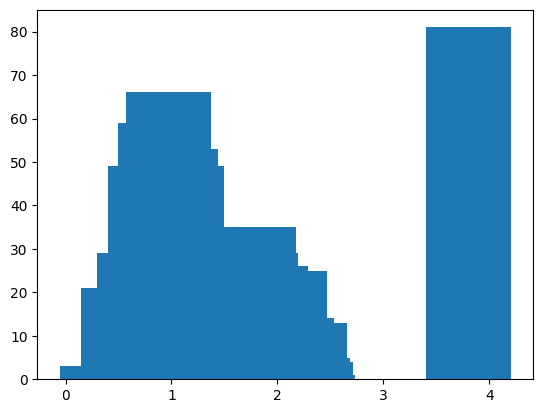

In [343]:
min_gyb = df[gyb].min()
max_gyb = df[gyb].max()
# there are two possible ways, either consider age divided by the number of garages
# or consider the square root or log of the age
gage = "gage"
df[gage] = np.log(np.sqrt((max_gyb + 2) - df[gyb]))

gage_counts = df[gage].value_counts()
plt.bar(gage_counts.index.values, gage_counts.values)
plt.show()
# the gage feature is promising
 

In [344]:
# let's drop gt, gf for the moment, as they do not seem to be as informative 
drop_cols([gt, gf])

In [345]:
garage_cols = [col for col in df.columns if col.lower().startswith("g")]
garage_cols.remove("GrLivArea")
print(garage_cols )

['GYb', 'gc', 'ga', 'gqua', 'gcond', 'gcond2', 'gstate', 'gage']


In [346]:
df[ga] = df_base[ga]

In [349]:
# let's consider the different relation between the two garage areas
print(df[[ga, gc, Y]].corr())
print(pd.pivot_table(df, values=ga, index=gc, aggfunc=agg_funcs))

# there is practically no difference between having 3 and 4 car capacity in a garage
# let's experiment with setting the 5 4-car capacity garages to 3
replace_values([gc, gc], [{4:3}, {5: 3}])
print(df[garage_cols].corr())

          ga        gc         y
ga  1.000000  0.882475  0.623431
gc  0.882475  1.000000  0.640409
y   0.623431  0.640409  1.000000
    count        mean median amin  amax
       ga          ga     ga   ga    ga
gc                                     
0.0    81    0.000000      0    0     0
1.0   369  300.517615    288  160   924
2.0   824  519.797330    506  320  1418
3.0   181  811.574586    818  478  1390
4.0     5  890.400000    864  480  1356
             GYb        gc        ga      gqua     gcond    gcond2    gstate  \
GYb     1.000000  0.603395  0.560766  0.963460  0.960605  0.771366  0.374083   
gc      0.603395  1.000000  0.882971  0.594054  0.585719  0.494980  0.634716   
ga      0.560766  0.882971  1.000000  0.560582  0.551967  0.488915  0.572247   
gqua    0.963460  0.594054  0.560582  1.000000  0.970609  0.827777  0.386440   
gcond   0.960605  0.585719  0.551967  0.970609  1.000000  0.888847  0.400512   
gcond2  0.771366  0.494980  0.488915  0.827777  0.888847  1.000000  

In [350]:
# let's investigate the effect of the area within the garage with the same car capacity
g1cap = df[df[gc] == 1]
g2cap = df[df[gc] == 2]
g3cap = df[df[gc] == 3]
gs = [g1cap, g2cap, g3cap]

In [351]:
for g in [g1cap, g2cap, g3cap]:
    print(g.loc[:, [Y, ga]].corr()[Y])  # numerically a garage's area is not of much relevance given the capacity is either 1 or 3

y     1.000000
ga    0.025078
Name: y, dtype: float64
y     1.000000
ga    0.209404
Name: y, dtype: float64
y     1.000000
ga    0.053138
Name: y, dtype: float64


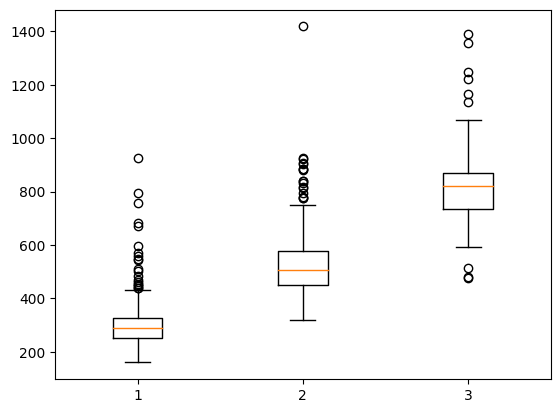

In [352]:
gcs = [g1cap[ga].values, g2cap[ga].values, g3cap[ga].values]
plt.boxplot(gcs)
plt.show()    

/tmp/ipykernel_7251/3049316836.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_no_out[ga] = np.log((g_no_out[ga]))
/tmp/ipykernel_7251/3049316836.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_no_out[Y] = g_no_out[Y] / (10 ** 4)


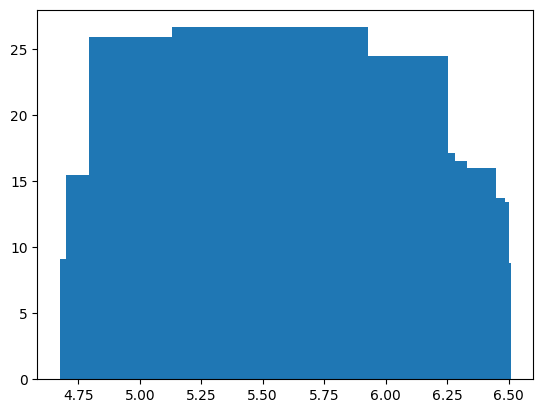

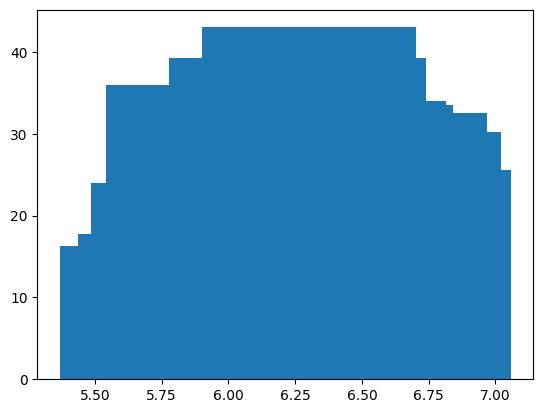

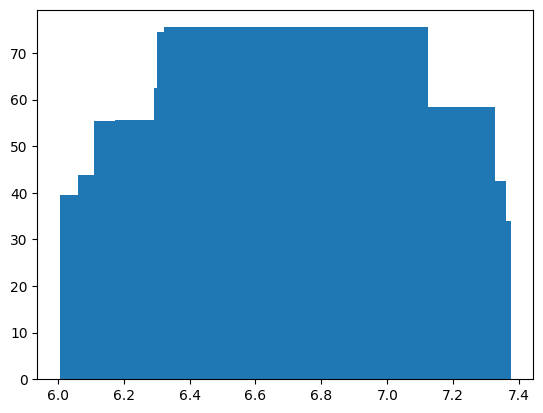

In [356]:
import itertools 

# let's check the case of garage capacity
ga_outliers = {1:[120, 450], 2: [250, 780], 3:[600, 1100]}
print()
# for g, out in zip(gs, ga_outliers):
#     g_no_out = g[g[ga] <= out]
#     g_no_out.plot(kind="scatter", y=Y, x=ga, title='price by garage area for {}-car garages'.format(str(i)))
#     i += 1
    
i = 1
# let's try rendering the data to normal distribution
for g, out in zip(gs, ga_outliers):
    g_no_out = g[(g[ga] <= ga_outliers[out][1]) & (g[ga] >= ga_outliers[out][0])]
    g_no_out[ga] = np.log((g_no_out[ga]))
    g_no_out[Y] = g_no_out[Y] / (10 ** 4)
    plt.bar(g_no_out[ga].values, g_no_out[Y].values)
    plt.show()
    
ga_outliers[0] = [0.0, 0.0]

In [357]:
def transform_garage_areas(row):
    # ga_outliers[row[gc]][0]: represents the minimum (no -outlier) area associated with the capacity of the garage 
    row[gc] = int(row[gc])
    row[ga] = max(ga_outliers[row[gc]][0], row[ga])
    row[ga] = min(ga_outliers[row[gc]][1], row[ga])
    row[ga] = np.log(np.sqrt(row[ga])) if row[ga] > 0 else 0
    return row   
apply_functions(transform_garage_areas)

<BarContainer object of 1460 artists>

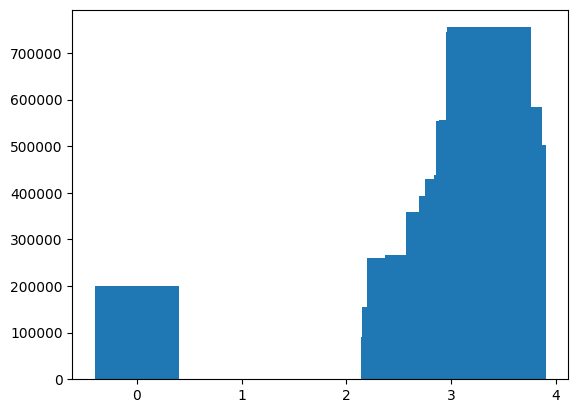

In [358]:
plt.bar(df[ga].values, df[Y].values)

In [359]:
# the garage area is to be dropped
drop_cols([gcond2, gcond, gqua, gyb])
garage_cols = [col for col in df.columns if col.lower().startswith("g")]
garage_cols.remove("GrLivArea")
print(garage_cols)

['gc', 'ga', 'gstate', 'gage']


In [360]:
X = df.copy()
y = X.pop(Y)
print(model_performance(X, y))

0.137012654323214


### Basement Features
The large number of basement-related features requires a better investigation of the relation between them. Feature engineering could pay off well in this aspect of the problem


In [361]:
print(df.columns.values)

['mss' 'MSZoning' 'LotFrontage' 'LotArea' 'LotShape' 'LandContour'
 'Neighborhood' 'Condition1' 'BldgType' 'HouseStyle' 'qua' 'cond' 'Yb'
 'Yr' 'RoofStyle' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'Foundation' 'bqua' 'bcond' 'bexp' 'bf1' 'bSF1' 'bf2'
 'b_unfSF' 'bSF' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'GrLivArea' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd' 'firep' 'firequa' 'gc' 'ga'
 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' 'ScreenPorch'
 'SaleType' 'SaleCondition' 'y' 'state' 'gstate' 'gage']


In [362]:
new_col_names({"TotalBsmtSF": "bSF", "bubf": "b_unfSF"})
bas_cols = [col for col in df.columns.values if col.lower().startswith("b")]
bas_cols.remove("BldgType")
bas_cols.remove( "BedroomAbvGr")
print(bas_cols)

['bqua', 'bcond', 'bexp', 'bf1', 'bSF1', 'bf2', 'b_unfSF', 'bSF']


#### Applying PCA on basement features
Due to the large number (8 features for one aspect), complexity and (potential) importance of basement features, it is worth experimenting with some 

In [363]:
print(df[bqua].value_counts())
df_base[bqua].value_counts()

3.0    1388
0.0      37
2.0      35
Name: bqua, dtype: int64


3    649
4    618
5    121
0     37
2     35
Name: bqua, dtype: int64

In [285]:
# before applying the PCA, we need to check for outliers
# for bcol in bas_cols:
#     plt.boxplot(df[bcol].values)
#     plt.show()
for bcol in bas_cols:
    print(df[bcol].value_counts())

3.0    1388
0.0      37
2.0      35
Name: bqua, dtype: int64
3.0    1376
2.0      45
0.0      37
1.0       2
Name: bcond, dtype: int64
1.0    953
3.0    355
2.0    114
0.0     38
Name: bexp, dtype: int64
3.0    501
1.0    430
6.0    418
2.0     74
0.0     37
Name: bf1, dtype: int64
0.0       467
24.0       12
16.0        9
686.0       5
662.0       5
         ... 
1338.0      1
1324.0      1
1460.0      1
328.0       1
830.0       1
Name: bSF1, Length: 637, dtype: int64
1.0    1256
3.0     106
2.0      46
0.0      38
6.0      14
Name: bf2, dtype: int64
0.0       118
728.0       9
384.0       8
600.0       7
300.0       7
         ... 
551.0       1
1257.0      1
605.0       1
467.0       1
136.0       1
Name: b_unfSF, Length: 780, dtype: int64
0.0       37
864.0     35
672.0     17
912.0     15
1040.0    14
          ..
1838.0     1
1581.0     1
707.0      1
611.0      1
1542.0     1
Name: bSF, Length: 721, dtype: int64


In [ ]:
print(df[bas_cols].corr())

In [ ]:
bSF = "bSF"
print(pd.pivot_table(df, index=bqua, values=bSF, aggfunc=agg_funcs))
# let's investigate the relation between the total area, finished and unfinished area
# using the base dataframe as the area of the 2nd basement has been deemed irrelevant
bSF1 = "bSF1"
df_base['b_sum_SF'] = df_base[bSF1] + df_base["b_unfSF"] + df_base["bSF2"]
total_no_sum = df_base[df[bSF] != df_base['b_sum_SF']].copy() 
print(total_no_sum.empty)
# so as indicated by the names of the columns, there is a relation between both the 4 surface features
# let's consider 2 main new features: ration_finished, finished surface

df['bfSF'] = df_base['bSF1'] + df_base['bSF2']
df_test['bfSF'] = df_test_base['bSF1'] + df_test_base['bSF2']

df['bf_ratio'] = df['bfSF'] / df[bSF]
df_test['bf_ratio'] = df_test['bfSF'] / df_test[bSF]


In [ ]:
print(pd.pivot_table(df, index=bcond, values=bqua, aggfunc=agg_funcs))
# let's consider the qualities of the condition 2 
print(df[df[bcond] == 2][bqua].value_counts()) # the majority of has quality 3
print(df[df[bcond] == 3][bqua].value_counts())
print(df[bqua].value_counts())

# so the point here is clear: bcondition is informative in a very specific way:
# condition = 0 or condition = 5 then quality = condition
# otherwise, no clear relation is visible for the moment

# let's consider the categorical feature b_is_ex
df['b_is_ex'] = (df[bcond] == 5).astype(int)
df_test['b_is_ex'] = (df_test[bcond] == 5).astype(int)

print(pd.pivot_table(df, index=bexp, values=bqua, aggfunc=agg_funcs)) # the feature does not seem to influence the 
# the quality of the basement.

print(pd.pivot_table(df, index=bf1, values=bqua, aggfunc=agg_funcs)) 

In [ ]:
# to fanalize the state of the basement
# I will introduce the bstate feature
# as the product to the (quality + b_is_ex) * np.log(b_exp + 2)
df['bstate'] = (df['bqua'] + df['b_is_ex']) * np.floor(np.log(df['bexp'] + np.exp(1)))
df_test['bstate'] = (df_test['bqua'] + df_test['b_is_ex']) * np.floor(np.log(df_test['bexp'] + np.exp(1)))

drop_cols(bas_cols + ['b_is_ex'])
X = df.copy()
y = X.pop(Y)
print(model_performance(X, y))

### Area features 
There is a number of features that represent a sort of areas in the house. I will try to investigate the different possible relations between those areas and how to make the most of them

In [75]:
area_features = [col for col in df.columns.values if 'area' in col.strip().lower() or 'sf' in col.strip().lower()]
print(area_features)

['LotArea', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'bfSF']


count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: area, dtype: float64


/tmp/ipykernel_7251/1740375244.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_area['area'] = np.log(norm_area['area'])


<AxesSubplot:xlabel='area', ylabel='y'>

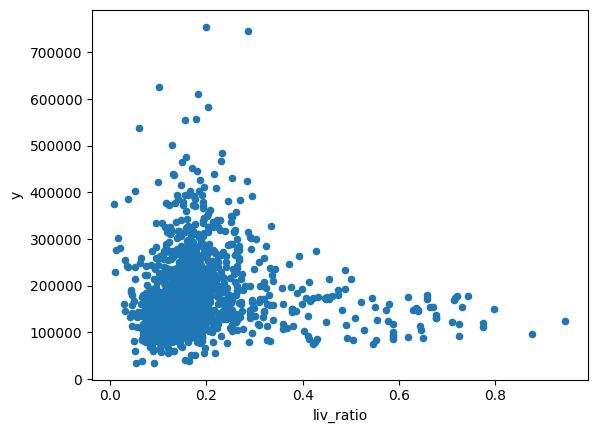

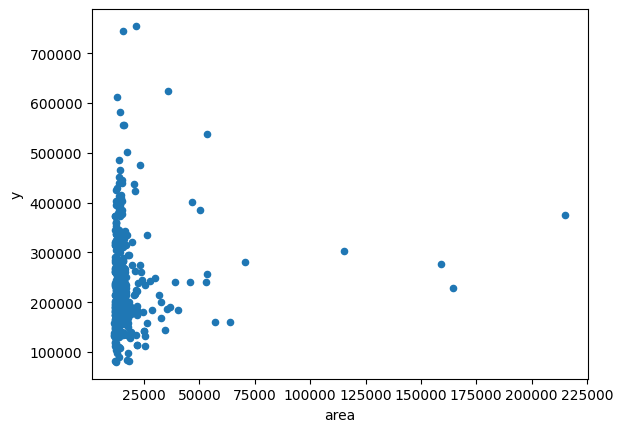

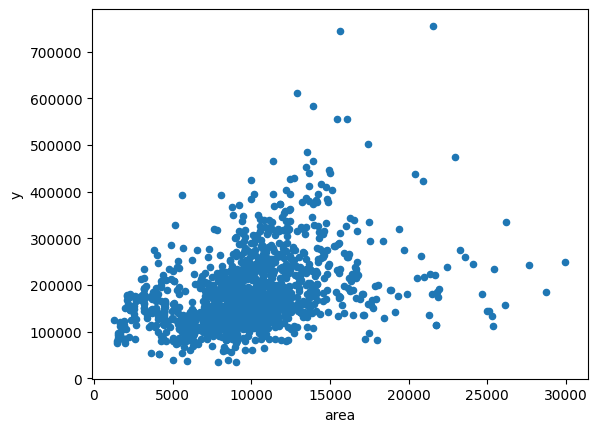

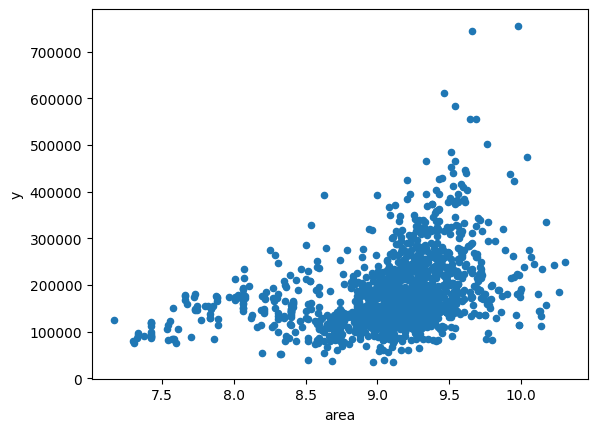

In [76]:
# we will consider the first 5 besides the MasVrnArea
new_col_names({"1stFlrSF": "f1SF","2ndFlrSF": "f2SF", "LotArea": "area", "GrLivArea": "liv_area"})

df['liv_ratio'] = df['liv_area'] /  df['area']
df.plot(kind='scatter', x='liv_ratio', y=Y)
# df.plot(kind='scatter', x='area', y=Y)
# the lot area's plot it remarkably skewed. Let's do two things:
## consider the values with extremely large lot areas (possible outliers)
## consider applying a mathematical transformation

# df[df['area'] <= 5 * 10 ** 4].plot(kind='scatter', x='area', y=Y)
print(df['area'].describe())
# the fourth quartile starts from 11600
fth_q_lot_area = 11600

sus_area = df[df['area'] > fth_q_lot_area]
sus_area.plot(kind='scatter', x='area', y=Y)
# apparently outliers start from 30k 

sus_area = df[df['area'] > 3 * 10 ** 4]
norm_area = df[df['area'] <= 3 * 10 ** 4]
norm_area.plot(kind='scatter', x='area', y=Y)
norm_area['area'] = np.log(norm_area['area'])
norm_area.plot(kind='scatter', x='area', y=Y) # close to normal distribution with a slightly high mean


In [77]:

# let's consider the behavior of rows in sus_area as the values are quite high while the prices are not following the trend
for col in df.columns:
    print(sus_area[col].value_counts())

20.0     11
60.0      6
190.0     3
50.0      2
Name: mss, dtype: int64
3.0    22
Name: MSZoning, dtype: int64
0.0      9
68.0     1
141.0    1
73.0     1
150.0    1
100.0    1
62.0     1
130.0    1
52.0     1
47.0     1
75.0     1
118.0    1
50.0     1
313.0    1
Name: LotFrontage, dtype: int64
50271.0     1
31770.0     1
63887.0     1
36500.0     1
32463.0     1
35133.0     1
35760.0     1
45600.0     1
53504.0     1
115149.0    1
46589.0     1
32668.0     1
40094.0     1
53227.0     1
70761.0     1
34650.0     1
53107.0     1
164660.0    1
215245.0    1
39104.0     1
159000.0    1
57200.0     1
Name: area, dtype: int64
1.0    11
2.0     6
0.0     3
3.0     2
Name: LotShape, dtype: int64
2.0    10
3.0     5
0.0     5
1.0     2
Name: LandContour, dtype: int64
3.0     8
23.0    4
7.0     2
15.0    2
24.0    1
12.0    1
8.0     1
6.0     1
22.0    1
11.0    1
Name: Neighborhood, dtype: int64
2.0    19
1.0     2
3.0     1
Name: Condition1, dtype: int64
0.0    19
1.0     3
Name: BldgType,